In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

2023-05-22 04:52:43.310432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 04:52:51.955956: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-22 04:52:51.957108: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

In [48]:
bucket_name = 'cloud-ai-platform-2e11e97a-0212-426c-b0fa-b1f124dd9ef2'
file_name = 'NLP_data_v2.json'
from google.cloud import storage
import json

# Instantiate a Google Cloud Storage client and specify required bucket and file
storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(file_name)

# Download the contents of the blob as a string and then parse it using json.loads() method
data = json.loads(blob.download_as_string(client=None))

In [49]:
df = pd.DataFrame(data)

In [4]:
df_sample = df.sample(100)

In [2]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 64


In [3]:
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 63 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### 1. ZSL

In [5]:
import ktrain

In [6]:
zsl = ktrain.text.ZeroShotClassifier()

In [9]:
# res = zsl.predict(text, labels=['negative', 'positive'], include_labels=True,
#             nli_template="The sentiment of this restaurant review is {}.",multilabel=False)
# max_tuple = max(res, key=lambda x: x[1])
# print(max_tuple[0])

In [10]:
df_sample.head(2)

,url,date,language,title,text,clean_text
134743,https://www.1news.co.nz/2022/07/05/artificial-...,1656979200000,en,Artificial intelligence used to boost rubbish ...,Artificial intelligence used to boost rubbish ...,Artificial intelligence used boost rubbish dum...
171166,https://www.komando.com/money/ai-fake-reviews/...,1682640000000,en,Scammers using AI to post fake reviews - And t...,\n\nScammers using AI to post fake reviews - A...,Scammers using AI post fake reviews And dead g...


In [28]:
text = 'the waiter is rude but This restaurant has excellent food, reasonably priced '

In [29]:
res = zsl.predict(text, labels=['negative', 'positive'], 
                      include_labels=True, 
                      nli_template="The sentiment of this text is {}.", 
                      multilabel=False)
max_tuple = max(res, key=lambda x: x[1])
max_tuple[0]

'positive'

In [11]:
%%time
sentiments = []
# doc_num = []
for text in df['title']:
    # doc_num.append(
    res = zsl.predict(text, labels=['negative', 'positive'], 
                      include_labels=True, 
                      nli_template="The sentiment of this text is {}.", 
                      multilabel=False, batch_size = 200)
    max_tuple = max(res, key=lambda x: x[1])
    sentiments.append(max_tuple[0])


CPU times: user 5d 5h 11min 11s, sys: 25min 13s, total: 5d 5h 36min 25s
Wall time: 3h 55min 15s


In [12]:
df['sentiment'] = sentiments

In [13]:
df_final = df.drop(columns = ['language','text','clean_text'])

In [14]:
df_final.to_parquet("gs://cloud-ai-platform-2e11e97a-0212-426c-b0fa-b1f124dd9ef2/df_final.parquet")

In [7]:
sentiment = pd.read_parquet("gs://cloud-ai-platform-2e11e97a-0212-426c-b0fa-b1f124dd9ef2/df_final.parquet")

In [8]:
sentiment.groupby('sentiment').count()

,url,date,title
sentiment,,,
negative,41088,41088,41088
positive,112429,112429,112429


In [10]:
pd.set_option('display.max_colwidth', None)

In [11]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153517 entries, 0 to 200330
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   url        153517 non-null  object
 1   date       153517 non-null  int64 
 2   title      153517 non-null  object
 3   sentiment  153517 non-null  object
dtypes: int64(1), object(3)
memory usage: 5.9+ MB


In [14]:
topics = pd.read_csv("gs://cloud-ai-platform-2e11e97a-0212-426c-b0fa-b1f124dd9ef2/prediction_df.csv")


In [15]:
topics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153517 entries, 0 to 153516
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      153517 non-null  int64  
 1   fraud           153517 non-null  float64
 2   healthcare      153517 non-null  float64
 3   robotic         153517 non-null  float64
 4   finance         153517 non-null  float64
 5   fake            153517 non-null  float64
 6   bot             153517 non-null  float64
 7   entertainment   153517 non-null  float64
 8   generative      153517 non-null  float64
 9   blockchain      153517 non-null  float64
 10  hardware        153517 non-null  float64
 11  security        153517 non-null  float64
 12  journalism      153517 non-null  float64
 13  legal           153517 non-null  float64
 14  administrative  153517 non-null  float64
 15  life science    153517 non-null  float64
 16  social science  153517 non-null  float64
 17  sales     

In [31]:
only_topic = topics[['topic']].reset_index()
sentiment = sentiment.reset_index()
sentiment = sentiment.drop(columns=['index'])

In [32]:
sentiment.head(2)

,level_0,url,date,title,sentiment
0,0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,1616025600000,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,positive
1,1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,1582761600000,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,positive


In [38]:
topic_with_sentiment = only_topic.join(sentiment, how='inner')
topic_with_sentiment = topic_with_sentiment[['url','topic','date','title','sentiment']]

In [41]:
topic_with_sentiment['date'] = pd.to_datetime(topic_with_sentiment['date'], unit='ms')


In [42]:
topic_with_sentiment.head(2)

,url,topic,date,title,sentiment
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,transportation,2021-03-18,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,positive
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,bot,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,positive


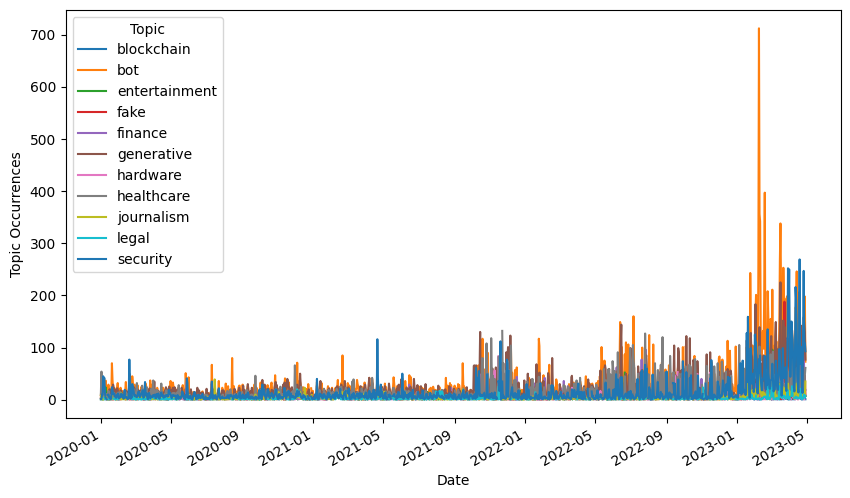

In [47]:

import matplotlib.pyplot as plt


topic_with_sentiment_popular = topic_with_sentiment[topic_with_sentiment.topic.isin(['finance','healthcare', 'robotic', 'finance', 'fake', 'bot', 'entertainment', 'generative', 'blockchain', 'hardware', 'security', 'journalism', 'legal'])]
# Group the data by date and topic, and count the occurrences
topic_counts = topic_with_sentiment_popular.groupby(['date', 'topic']).size().unstack()

# Set up the plot with custom figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Replace (10, 6) with your desired figure size

# Plot the topic occurrences by date
topic_counts.plot(kind='line', ax=ax)

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Topic Occurrences')
ax.legend(title='Topic')

# Display the plot
plt.show()

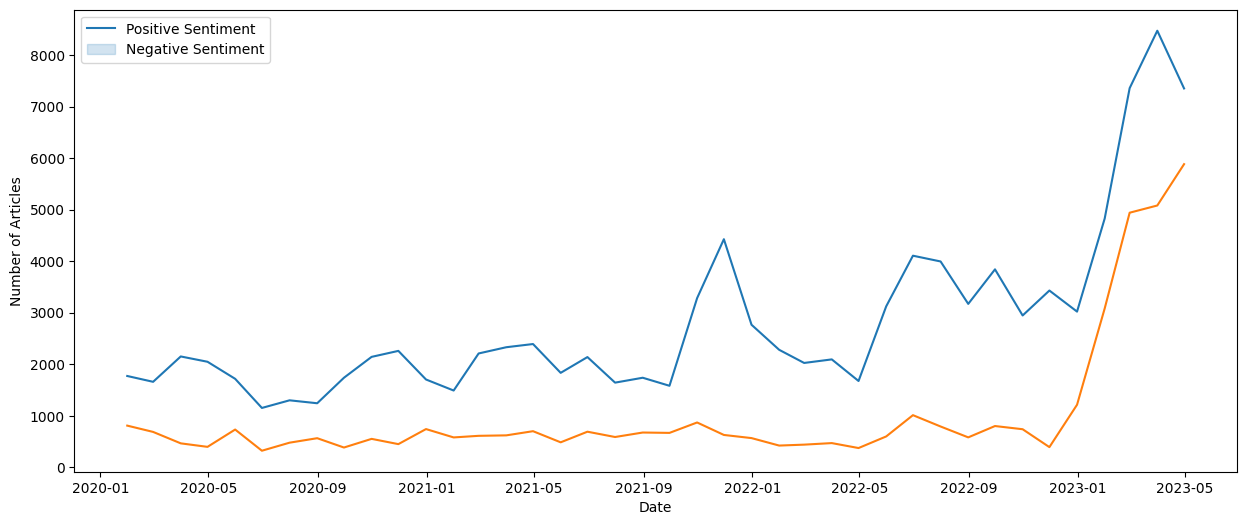

In [87]:
import seaborn as sns
# Filter the data for two sentiment values
sentiment_1 = topic_with_sentiment[topic_with_sentiment['sentiment'] == 'positive']
sentiment_2 = topic_with_sentiment[topic_with_sentiment['sentiment'] == 'negative']

# Group the filtered data by date and sentiment, and count the occurrences
counts_1 = sentiment_1.groupby(pd.Grouper(key='date', freq='M')).size()
counts_1 = counts_1.reset_index(name='counts')
counts_2 = sentiment_2.groupby(pd.Grouper(key='date', freq='M')).size()
counts_2 = counts_2.reset_index(name='counts')


# Set up the plot with custom figure size
# fig, ax = plt.subplots(figsize=(10, 6))  # Replace (10, 6) with your desired figure size

plt.figure(figsize=(15,6))
sns.lineplot(x='date',y='counts',data=counts_1)
sns.lineplot(x='date',y='counts',data=counts_2)
plt.legend(labels=['Positive Sentiment','Negative Sentiment'])
plt.xlabel('Date')
plt.ylabel('Number of Articles')


plt.show()

In [68]:
counts_1.count

<bound method DataFrame.count of            date  count
0    2020-01-01     25
1    2020-01-02    102
2    2020-01-03     70
3    2020-01-04     28
4    2020-01-05     15
...         ...    ...
1209 2023-04-24    368
1210 2023-04-25    604
1211 2023-04-26    448
1212 2023-04-27    490
1213 2023-04-28    226

[1214 rows x 2 columns]>

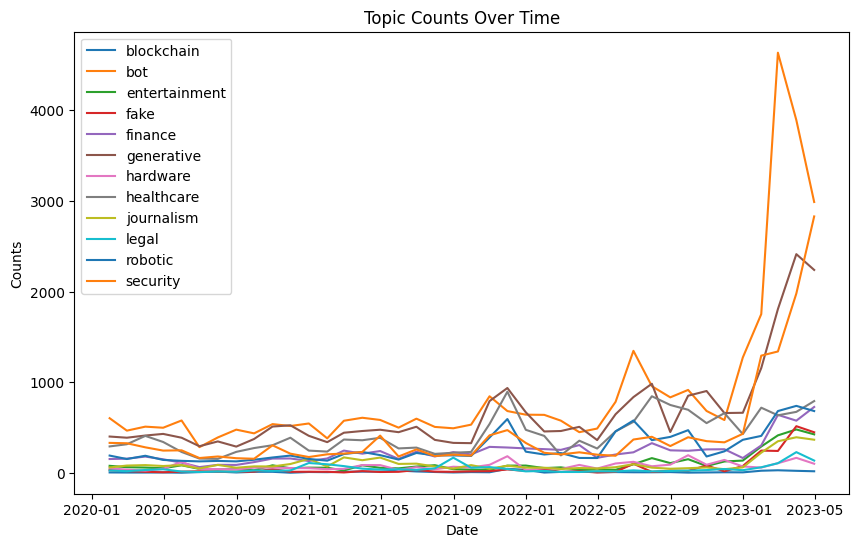

In [93]:
# Group by 'date' and 'topic', count occurrences
topic_with_sentiment_popular = topic_with_sentiment[topic_with_sentiment.topic.isin(['finance','healthcare', 'robotic', 'finance', 'fake', 'bot', 'entertainment', 'generative', 'blockchain', 'hardware', 'security', 'journalism', 'legal'])]
topic_counts = topic_with_sentiment_popular.groupby([pd.Grouper(key='date', freq='M'), 'topic']).size().reset_index(name='counts')

# Plotting time series with separate lines for each topic
plt.figure(figsize=(10, 6))
topics = topic_counts['topic'].unique()

for topic in topics:
    data = topic_counts[topic_counts['topic'] == topic]
    plt.plot(data['date'], data['counts'], label=topic)

plt.xlabel('Date')
plt.ylabel('Counts')
plt.title('Topic Counts Over Time')
plt.legend()
plt.show()

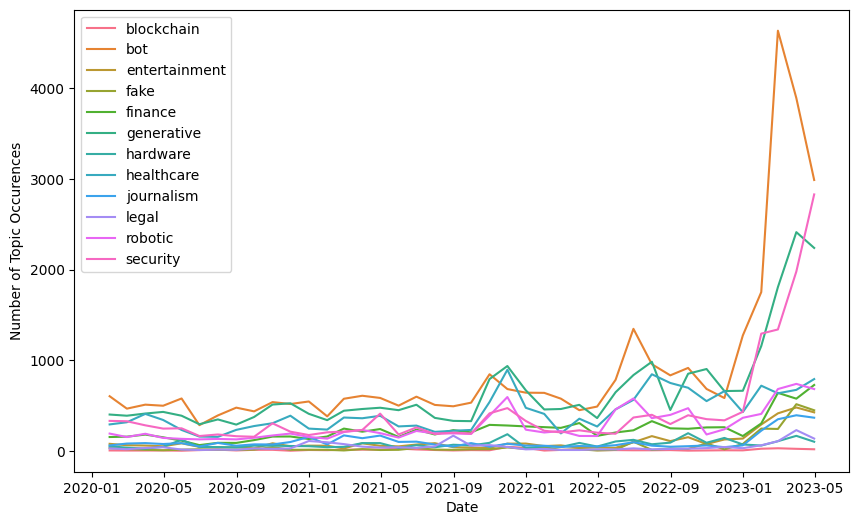

In [97]:
# Group by 'date' and 'topic', count occurrences
topic_counts = topic_with_sentiment_popular.groupby([pd.Grouper(key='date', freq='M'), 'topic']).size().reset_index(name='counts')

# Plotting time series with separate lines for each topic using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=topic_counts, x='date', y='counts',hue='topic')

plt.xlabel('Date')
plt.ylabel('Number of Topic Occurences')
# plt.title('Topic Counts Over Time')
plt.legend()
plt.show()

In [98]:
sentiment.shape

(153517, 5)

In [99]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153517 entries, 0 to 153516
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   level_0    153517 non-null  int64 
 1   url        153517 non-null  object
 2   date       153517 non-null  int64 
 3   title      153517 non-null  object
 4   sentiment  153517 non-null  object
dtypes: int64(2), object(3)
memory usage: 5.9+ MB


In [100]:
sentiment.title.value_counts()

Virtus Artificial Intelligence &amp; Technology Opportunities Fund Discloses Sources of Distribution - Section 19(a) Notice                                             237
Virtus AllianzGI Artificial Intelligence &amp; Technology Opportunities Fund Discloses Sources of Distribution - Section 19(a) Notice                                   119
Trump arrested? Putin jailed? Fake AI images spread online                                                                                                               99
Musk, scientists call for halt to AI race sparked by ChatGPT                                                                                                             97
Biden administration seeks input on AI safety measures                                                                                                                   86
                                                                                                                                            